Comment:
* Truck battery is not container yet
* Decition making for charging here or next depot not in





In [ ]:
import simpy
import weakref
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from numpy import where
import matplotlib.pyplot as plt
import math
from cmath import nan
import random

In [ ]:
# Generate routes


from operator import index


#slod = 'O:\\I\\Íslensk nýorka_3992\\100521_Orkuskipti þungabifreiða\\Forritun líkans\\Atli\\Efla-Trukkar\\'
slod = 'C:\\Users\\Notandi\\Efla\\Efla-Trukkar\\'
samantekt = slod+'Samantekt.xlsx'

Samantekt_df = pd.read_excel(samantekt,sheet_name='Samantekt1')
Samantekt_df.dropna(how='all',inplace=True)
Samantekt_df['Stop time']=Samantekt_df['Stop time'].fillna(0)

Samantekt_df['Departure time'] = Samantekt_df['Departure time'].astype('string')
Samantekt_df['Departure time']= Samantekt_df['Departure time'].str.split(':').apply(lambda x: int(x[0])*60+int(x[1]))



ReturnTrip = Samantekt_df.copy()
ReturnTrip['Departure time'] +=1440

Samantekt_df = pd.concat([Samantekt_df,ReturnTrip])

Route = pd.DataFrame()

for row in range(len(Samantekt_df)):
    
    repeat = int(Samantekt_df.iloc[row]['Repeat'])
    depart = int(Samantekt_df.iloc[row]['Departure time'])
    speed = int(Samantekt_df.iloc[row]['Average speed'])
    for i in range(repeat):
        newrow = Samantekt_df.iloc[row]
        newrow['Average speed'] = random.randrange(round(speed-speed*0.1),round(speed+speed*0.1))
        depart = random.randrange(depart,depart+10)
        newrow['Departure time'] = depart
        Route = Route.append(newrow)


Route.reset_index(inplace=True)
Route = Route.drop(columns=['Repeat','index'])
#Route.to_excel("Routes1.xlsx")


#slod = 'O:\\I\\Íslensk nýorka_3992\\100521_Orkuskipti þungabifreiða\\Forritun líkans\\Atli\\Efla-Trukkar\\'
vegalengdir_file = slod+'LeiðaFylki.xlsx'
input_file = slod + 'Test input.xlsx'



Vegalengdir = pd.read_excel(vegalengdir_file, skiprows=13, index_col=0)

# Trukkar sem koma til greina, Eins og er simplified og bara 1 týpa 
Trukkar = pd.read_excel(input_file, sheet_name="Sheet1", index_col=0)


# Tengja trukka við leiðir og fá þær upplýsingar sem þarf
Leidir = pd.merge(Route,Trukkar,on="Truck Type")

# Depot í String
try:
    Leidir['Depot'] = Leidir.Depot.apply(lambda x: x.split(','))
except:
    pass

# Departure time to minutes 
#Leidir['Departure time'] = Leidir['Departure time'].astype('string')
#Leidir['Departure time']= Leidir['Departure time'].str.split(':').apply(lambda x: int(x[0])*60+int(x[1]))




Leidir['Nr Leiðar'] = Leidir.index +1
Leidir.to_excel("Routes1.xlsx")


C:\Users\Notandi\AppData\Local\Temp\ipykernel_5980\469499582.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Route = Route.append(newrow)
C:\Users\Notandi\AppData\Local\Temp\ipykernel_5980\469499582.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Route = Route.append(newrow)
C:\Users\Notandi\AppData\Local\Temp\ipykernel_5980\469499582.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Route = Route.append(newrow)
C:\Users\Notandi\AppData\Local\Temp\ipykernel_5980\469499582.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Route = Route.append(newrow)
C:\Users\Notandi\AppData\Local\Temp\ipykernel_5980\469499582.py:37: Futu

In [ ]:
def get_distance(Departure,Depot,Destination):
    #print(f'Depart {Departure}. Depot {Depot}. Destination {Destination}')
    try:
        to_stop = Vegalengdir[Departure].loc[Depot]
    except:
        to_stop = Vegalengdir[Depot].loc[Departure]
    try:
        from_stop = Vegalengdir[Destination].loc[Depot]
    except:
        from_stop = Vegalengdir[Depot].loc[Destination]
    if math.isnan(to_stop) or math.isnan(from_stop):
        print(f'Errors in Distances for Departure {Departure}. Depot {Depot}. Destination {Destination}')
    return to_stop,from_stop

In [ ]:
global truck_data
truck_data = pd.DataFrame()
global depot_data
depot_data = pd.DataFrame()

class Route:
    instances = []
    def __init__(self,env,name,BatterySize,MaxCharge,Range,Departure,Departure_time,Destination,Depot1,
    speed, truck_type,SOC_at_start,stop_time,DepotList,MIN_ARRIVAL_SOC
    ):
        self.env = env
        self.name = 'Truck '+ str(name) 
        self.battery_size_kwh = BatterySize
        self.MaxCharge_kw = MaxCharge
        self.range_km = Range
        self.Departure_loc = Departure
        self.Departure_time = Departure_time
        self.Destination_loc = Destination
        self.speed_km_h = speed
        self.truck_type = truck_type
        self.battery_SOC = SOC_at_start
        #self.Stop_time = stop_time.split(sep=",")
        self.DepotList = DepotList
        self.MIN_ARRIVAL_SOC = MIN_ARRIVAL_SOC
        self.Eydsla = 1/self.range_km
        self.ChargingPower = 0
        self.d = {} # data collection

        self.Depot_names= Depot1
        if self.Depot_names == self.Destination_loc:
            self.stops = 0
        else:
            self.stops = len(self.Depot_names)

        self.d.update({
            'Truck':self.name,
            'Departure loc':self.Departure_loc,
            'Destination loc':self.Destination_loc,
            'Departure time':self.Departure_time,
            'Stops':self.stops,
            'Depot':self.Depot_names,
            'SOC at start':self.battery_SOC,
        })
        # Start trip
        self.run = env.process(self.RouteSetUp(env))


    def RouteSetUp(self,env):

        # Timeout until departure time
        departure = env.process(self.departure(env,self.Departure_time))
        yield departure

        self.Depot_stops = 0
        while self.Depot_stops < self.stops:
            if self.stops > 1:
                if self.Depot_stops == 0:   
                    self.to_depot_km,self.from_depot_km=get_distance(
                        self.Departure_loc,self.Depot_names[self.Depot_stops],self.Depot_names[self.Depot_stops+1])
                    self.Current_Depot = self.Depot_names[self.Depot_stops]
                elif self.Depot_stops+1 == self.stops:
                    self.to_depot_km,self.from_depot_km=get_distance(
                        self.Depot_names[self.Depot_stops-1],self.Depot_names[self.Depot_stops],self.Destination_loc)
                    self.Current_Depot = self.Depot_names[self.Depot_stops]
                else:
                    self.to_depot_km,self.from_depot_km=get_distance(
                        self.Depot_names[self.Depot_stops-1],self.Depot_names[self.Depot_stops],self.Depot_names[self.Depot_stops+1])            
                    self.Current_Depot = self.Depot_names[self.Depot_stops]
            else:
                self.to_depot_km,self.from_depot_km=get_distance(
                    self.Departure_loc,self.Depot_names[self.Depot_stops],self.Destination_loc)
                self.Current_Depot = self.Depot_names[self.Depot_stops]


            self.TimeToDepot = (self.to_depot_km / self.speed_km_h)*60
            self.TimeFromDepot = (self.from_depot_km / self.speed_km_h)*60
            self.Desired_SOC = self.Eydsla*self.from_depot_km + self.MIN_ARRIVAL_SOC
            if self.Desired_SOC > 1:
                self.Desired_SOC = 1
            self.battery_SOC = self.battery_SOC - (self.Eydsla*self.to_depot_km) # Battery at depot


            # Data collect ---
            DistanceToDepot = 'Distance to Depot '+str(self.Depot_stops)
            DistanceFromDepot = 'Distance from Depot '+str(self.Depot_stops)
            SOCAtDepot = 'SOC at depot '+str(self.Depot_stops)
            SOCFromDepot = 'SOC from depot '+str(self.Depot_stops)
            self.d.update({ #Uppdate
                DistanceToDepot:self.to_depot_km,
                DistanceFromDepot :self.from_depot_km,
                SOCAtDepot:self.battery_SOC,
            })
            
            if self.battery_SOC > self.Desired_SOC:
                self.d.update({SOCFromDepot:self.battery_SOC})
            else:  
                self.d.update({SOCFromDepot:self.Desired_SOC})
            # ---

            trip = env.process(self.trip(env))
            yield trip

        # Driving to End
        driving = env.process(self.Driving(env,self.TimeFromDepot))
        yield driving

        # Time and SOC at end. 
        self.battery_SOC = self.battery_SOC - (self.Eydsla*self.from_depot_km) # Battery at depot
        self.d.update({'Destination time':env.now,
                    'Destination SOC':self.battery_SOC
        })

        # Slow Charging
        # Assuming the truck has same depart time as before
        self.UntilNextTrip = self.Departure_time +1440 - env.now
        #Power needed to fully charge
        powerneeded = ((1-self.battery_SOC)*(self.battery_size_kwh*60))/(self.UntilNextTrip-120)
        
        #slowcharge
        slow = env.process(self.SlowCharge(env))
        yield slow



        # returns data from trip to Global dataframe
        global truck_data
        a = pd.Series(data=self.d)
        truck_data= pd.concat([truck_data,pd.DataFrame(a).T],axis=0)


    def trip(self,env):

        # Data 
        DepotArrival = 'Depot Arrival '+str(self.Depot_stops)
        DepotCharging = 'Depot Charging '+str(self.Depot_stops)
        DepotLeaving = 'Depot Leaving '+str(self.Depot_stops)
        SOCFromDepot = 'SOC from depot '+str(self.Depot_stops)

        # Driving time 
        driving = env.process(self.Driving(env,self.TimeToDepot))
        yield driving

        self.d.update({DepotArrival:env.now})
        self.DepotArrival = env.now
        

        
        if self.Current_Depot in self.DepotList: # Test if duplicting here will work
            # Depot to stop at
            self.depot = eval(self.Current_Depot)
            self.depot.Trucks_at_depot += 1
            self.depot.d1.loc[len(self.depot.d1.index)] = [env.now,self.depot.Trucks_at_depot] #data
            
        if self.Current_Depot in self.DepotList:
            # Request port
            
            
            request = self.depot.charging_ports.request
            if self.battery_SOC < self.Desired_SOC:
                # Gets port
                with self.depot.charging_ports.request() as req:
                    yield req
                    self.d.update({DepotCharging:env.now})
                    self.ChargingStart = env.now
                    self.depot.Port_change(env)
                    # Adds itself to charging list 
                    self.__class__.instances.append(weakref.proxy(self))

                    # Charges til desired SOC
                    while self.battery_SOC+0.01 < self.Desired_SOC:               
                        self.depot.Port_change(env)
                        self.charging = env.process(self.Charging(env))
                        yield self.charging

                    # Removes from charging list
                    self.__class__.instances.remove(weakref.proxy(self))
                    self.depot.charging_ports.release(req)
                    self.depot.Port_change(env)
                    self.depot.Ports_Status(env)

            else:
                self.d.update({DepotCharging:env.now})
        else:
            self.d.update({DepotCharging:env.now})

        self.d.update({DepotLeaving:env.now})
        self.d.update({SOCFromDepot:self.battery_SOC})
        if self.Current_Depot in self.DepotList:
            self.depot.Trucks_at_depot -= 1
            self.depot.d1.loc[len(self.depot.d1.index)] = [env.now,self.depot.Trucks_at_depot] #data vehicles at depot
        try:
            self.depot.d2.loc[len(self.depot.d2.index)] = [self.ChargingStart-self.DepotArrival] #waiting time
            self.depot.d4.loc[len(self.depot.d4.index)] = [env.now-self.ChargingStart] #charging time
            self.depot.d5.loc[len(self.depot.d5.index)] = [env.now-self.DepotArrival] #charging time
        except:
            pass

        
        self.Depot_stops +=1
        
    def Charging(self,env):
        self.last_event_time = env.now  # At the start of charging

        try:
            # Get max power avilable, either max or split
            Avilable_Power = self.depot.Ports_Status(env)
            if Avilable_Power > self.MaxCharge_kw:
                self.ChargingPower = self.MaxCharge_kw
            else: 
                self.ChargingPower = Avilable_Power

            
            #yield self.depot.available_power.get(self.ChargingPower)
            
            Depart = self.battery_size_kwh/self.ChargingPower*60*(self.Desired_SOC-self.battery_SOC)
            print(f'{self.name} gets depart time {Depart}, Desired SOC: {self.Desired_SOC}, Will end with {self.battery_SOC + (Depart*self.ChargingPower)/(self.battery_size_kwh*60)}')

            yield env.timeout(Depart)
            #yield self.depot.available_power.put(self.ChargingPower)
            self.Update_SOC(env)

        except simpy.Interrupt as i:
            if self.depot.available_power.level != self.depot.available_power.capacity:
                yield self.depot.available_power.put(self.ChargingPower)
            self.Update_SOC(env)

    def SlowCharge(self,env):
        self.last_event_time = env.now
        self.depot = eval(self.Destination_loc)
        self.MaxCharge_kw = 100
        Depart = self.battery_size_kwh/self.MaxCharge_kw*60*(1-self.battery_SOC)
        # Adds itself to charging list 
        self.__class__.instances.append(weakref.proxy(self))
        self.depot.Ports_Status(env)
        self.depot.Trucks_at_depot_slow += 1
        self.depot.d3.loc[len(self.depot.d3.index)] = [env.now,self.depot.Trucks_at_depot_slow] #data vehicles at depot
        

        yield env.timeout(Depart)
        self.Update_SOC(env)
        self.__class__.instances.remove(weakref.proxy(self))
        self.depot.Ports_Status(env)
        self.depot.Trucks_at_depot_slow -= 1
        self.depot.d3.loc[len(self.depot.d3.index)] = [env.now,self.depot.Trucks_at_depot_slow] #data vehicles at depot

        return

    def departure(self,env,time):
        yield env.timeout(time)

    def Driving(self,env,time):
        yield env.timeout(time)

    def Update_SOC(self,env):
        
        time = env.now - self.last_event_time
        if self.battery_SOC + (time*self.ChargingPower)/(self.battery_size_kwh*60) <= 1:
            self.battery_SOC = self.battery_SOC + (time*self.ChargingPower)/(self.battery_size_kwh*60)
        else:
            self.battery_SOC = 1
        self.last_event_time = env.now
        print(f'{self.name} SOC {self.battery_SOC}')
        return

    '''
    def InterruptTruck(self,env):
        try:
            yield self.depot.available_power.put(self.ChargingPower)
            self.Update_SOC(env)
            print(f'{self.name} with SOC: {self.battery_SOC}')
        except:
            print("Error in interruption")

    def InterruptDepot(self,env): # Interuptar bara tiltekna depot, ekki lengur. 
        for i in Route.instances: 
            yield self.depot.available_power.put(self.ChargingPower)
            self.Update_SOC(env)

    '''

    def InterruptTruck(self,env):
        try:
            self.charging.interrupt()
        except:
            print("Error in interruption")
            print(f' At {env.now}')

    def InterruptDepot(self,env): # Interuptar bara tiltekna depot, 
        charging_at_depot = [inst for inst in Route.instances if inst.depot == self]
        for i in charging_at_depot: 
            Route.InterruptTruck(i,env)


In [ ]:
class Depot:
    instances = []
    def __init__(self,name,env,port,max_power):
        self.__class__.instances.append(weakref.proxy(self))
        self.charging_ports = simpy.Resource(env,port) 
        self.available_power = simpy.Container(env, init=max_power, capacity=max_power)
        self.name = name
        self.depot_max = max_power
        self.Port_Max = max_power
        self.Port_in_use = 0
        self.Last_Interrupt = 0
        self.Trucks_at_depot = 0
        self.Trucks_at_depot_slow = 0
        
        self.power_name = self.name + ' Power'
        self.time_name = self.name + ' Time'
        self.d = pd.DataFrame({self.time_name:[0,0],self.power_name:[0,0]})
        self.d1 = pd.DataFrame({self.time_name:[0,0],'Vehicles at port':[0,0]})
        self.d1.loc[len(self.d1.index)] = [0,0] #data

        # Waiting time
        self.d2 = pd.DataFrame({'Waiting time':[0]})

        # Slow charging
        self.d3 = pd.DataFrame({self.time_name:[0,0],'Vehicles at port':[0,0]})
        self.d3.loc[len(self.d3.index)] = [0,0] #data

        # charging time
        self.d4 = pd.DataFrame({'Charging time':[0]})

        # charging time
        self.d5 = pd.DataFrame({'Total time':[0]})



    def Ports_Status(self,env):
        # Returns port max, collect data for port
        PowerRequest = 0
        for i in Route.instances:
            if i.depot == self:
                PowerRequest += i.MaxCharge_kw

        self.d.loc[len(self.d.index)] = [env.now,PowerRequest] #data
        

        '''
        if PowerRequest > self.depot_max:
            self.Port_Max = (self.depot_max/int(self.charging_ports.count))
            self.d.loc[len(self.d.index)] = [env.now,self.depot_max] #data
        else:
            self.Port_Max = self.depot_max
            self.d.loc[len(self.d.index)] = [env.now,PowerRequest] #data
        
        '''
        return self.Port_Max

    def Port_change(self,env):
        return
        # The dissapearing truck happens here. 
        
        if self.charging_ports.count == self.Port_in_use:
            if self.Last_Interrupt != env.now:
                Route.InterruptDepot(self,env)
                self.Last_Interrupt = env.now
            self.Port_in_use = self.charging_ports.count
            return
        elif self.charging_ports.count == 1 and self.Port_in_use ==0:
            return
        else:
            if self.Last_Interrupt != env.now:
                Route.InterruptDepot(self,env)
                self.Last_Interrupt = env.now
            self.Port_in_use = self.charging_ports.count
            return

In [ ]:
MIN_ARRIVAL_SOC = 0.2

env = simpy.Environment()
#global truck_data

Reykjavík = Depot('Reykjavík',env,4,500)
Akureyri = Depot('Akureyri',env,4,500)
Húsavík = Depot('Húsavík',env,4,500)
Ísafjörður = Depot('Ísafjörður',env,4,500)
Patreksfjörður = Depot('Patreksfjörður',env,4,500)
Höfn = Depot('Höfn',env,4,500)
Egilsstaðir = Depot('Egilsstaðir',env,4,500)
Reyðarfjörður = Depot('Reyðarfjörður',env,4,500)
Landeyjahöfn = Depot('Landeyjahöfn',env,4,500)
Selfoss = Depot('Selfoss',env,4,500)
Vík = Depot('Vík',env,4,500)
Flúðir = Depot('Flúðir',env,4,500)
Þorlákshöfn = Depot('Þorlákshöfn',env,4,500)
Grundarfjörður = Depot('Grundarfjörður',env,4,500)
Ólafsvík = Depot('Ólafsvík',env,4,500)
Sauðárkrókur = Depot('Sauðárkrókur',env,4,500)
Blönduós = Depot('Blönduós',env,4,500)
Hvammstangi = Depot('Hvammstangi',env,4,500)
Keflavík = Depot('Keflavík',env,4,500)
Hella = Depot('Hella',env,4,500)
Hvolsvöllur = Depot('Hvolsvöllur',env,4,500)
Búðardalur = Depot('Búðardalur',env,4,500)
Staðarskáli = Depot('Staðarskáli',env,20,300)
Borgarnes = Depot('Borgarnes',env,4,500)
Freysnes = Depot('Freysnes',env,4,1000)
Djúpivogur = Depot('Djúpivogur',env,4,500)
Siglufjörður = Depot('Siglufjörður',env,4,500)
Dalvík = Depot('Dalvík',env,4,500)
Mývatn = Depot('Mývatn',env,4,500)
Þórshöfn = Depot('Þórshöfn',env,4,500)
Fáskrúðsfjörður = Depot('Fáskrúðsfjörður',env,4,500)
Seyðisfjörður = Depot('Seyðisfjörður',env,4,500)
Kirkjubæjarklaustur = Depot('Kirkjubæjarklaustur',env,4,500)







DepotList = []
for count, instance in enumerate(Depot.instances):
    DepotList.append(instance.name)



for index,row in Leidir.iterrows():
    Route(env,
        row['Nr Leiðar'],
        row['Battery size'],
        row['Max charge'],
        row['Range'],
        row['Departure'],
        row['Departure time'],
        row['Destination'],
        row['Depot'],
        row['Average speed'],
        row['Truck Type'],
        row['Battery at start'],
        row['Stop time'],
        DepotList,
        MIN_ARRIVAL_SOC
    )

env.run()



truck_data.to_excel("SimpyOutput.xlsx")


Truck 106 SOC 0.7485714285714287
Truck 115 gets depart time 58.83428571428573, Desired SOC: 0.842857142857143, Will end with 0.842857142857143
Truck 108 gets depart time 53.628342857142854, Desired SOC: 0.8685714285714285, Will end with 0.8685714285714285
Truck 121 gets depart time 38.509714285714296, Desired SOC: 0.6657142857142857, Will end with 0.6657142857142857
Truck 172 gets depart time 25.958400000000008, Desired SOC: 0.46285714285714286, Will end with 0.4628571428571428
Truck 125 gets depart time 26.243657142857156, Desired SOC: 0.7314285714285715, Will end with 0.7314285714285715
Truck 124 gets depart time 26.243657142857156, Desired SOC: 0.7314285714285715, Will end with 0.7314285714285715
Truck 115 SOC 0.8428571428571426
Truck 121 SOC 0.6657142857142855
Truck 109 SOC 0.5714285714285714
Truck 172 SOC 0.4628571428571426
Truck 108 SOC 0.8685714285714279
Truck 125 SOC 0.7314285714285715
Truck 124 SOC 0.7314285714285715
Truck 113 SOC 0.8
Truck 103 SOC 0.7085714285714286
Truck 110

spines = ["top","right","left","bottom"]
fig,ax = plt.subplots(5,1,figsize=(50,50),gridspec_kw={'height_ratios': [6,1,1,1,1]})

upper_text = 0.25
lower_text = -0.35

y = 1
for index, row in truck_data.sort_values('Departure time').iterrows():
    stops = 0

    ax[0].plot([row['Departure time'],row['Depot Arrival 0']],[y,y],'ko-',label = "Driving")
    ax[0].text((row['Departure time']+row['Depot Arrival 0'])/2,y+lower_text,str(row['Distance to Depot 0'])+' km',ha="center")

    while stops < row['Stops']:
        KMFROMDEPOT = 'Distance from Depot '+str(stops)
        SOCATDEPOT = 'SOC at depot '+str(stops)
        SOCFROMDEPOT = 'SOC from depot '+str(stops)
        DEPOTARRIVAL = 'Depot Arrival '+str(stops)
        DEPOTCHARGING = 'Depot Charging '+str(stops)
        DEPOTLEAVING = 'Depot Leaving '+str(stops)
        LASTDEPOTLEAVING = 'Depot Leaving '+str(stops-1)
        DEPOT = row['Depot'][stops]

        if row[DEPOTARRIVAL] == row[DEPOTLEAVING]:
            ax[0].plot([row[DEPOTARRIVAL], row[DEPOTLEAVING]], [y,y], 'go-', label = "Does not need charging",zorder = 5)
        else:
            ax[0].plot([row[DEPOTARRIVAL],row[DEPOTCHARGING]],[y,y],'ro-',label = 'Waiting at depot' ,zorder = 3)
            ax[0].plot([row[DEPOTCHARGING],row[DEPOTLEAVING]],[y,y],'bo-',label = 'Charging',zorder = 4 )

            ax[0].text(row[DEPOTARRIVAL], y+upper_text, np.round(row[SOCATDEPOT]*100,0).astype(int).astype(str)+"%", ha="right")
            ax[0].text(row[DEPOTLEAVING], y+upper_text, np.round(row[SOCFROMDEPOT]*100,0).astype(int).astype(str)+"%", ha="left")

        if stops >= 1:
            ax[0].plot([row[LASTDEPOTLEAVING],row[DEPOTARRIVAL]],[y,y],'ko-',label = "Driving")

        
        ax[0].text((row[DEPOTARRIVAL]+row[DEPOTLEAVING])/2,y+lower_text,DEPOT,ha="center")

        stops +=1
    ax[0].text(row['Departure time']-50, y, row['Departure loc'], ha="center" ) 
    ax[0].text(row['Destination time']+70, y, row['Destination loc'], ha="center" )
    ax[0].text(row['Departure time'], y+upper_text, str(round(row['SOC at start']*100,0))+'%', ha="center" )
    ax[0].text(row['Destination time'], y+upper_text, str(round(row['Destination SOC']*100,0))+'%', ha="center" )
    
    ax[0].plot([row[DEPOTLEAVING],row['Destination time']],[y,y],'ko-',label = "Driving")
    ax[0].text((row[DEPOTLEAVING]+row['Destination time'])/2,y+lower_text,str(row[KMFROMDEPOT])+' km',ha="center")
        
    y +=1

ax[0].set_yticks(np.arange(1,len(truck_data)+1))
ax[0].set_yticklabels(['Truck '+str(i) for i in np.arange(1,len(truck_data)+1)])

handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys(),loc='upper left')


for count, instance in enumerate(Depot.instances):
    df = pd.DataFrame()
    df = instance.d.drop_duplicates(subset=[instance.time_name],keep='last')
    df = df.reset_index(drop=True)
    ax[count+1].plot(df[instance.time_name],df[instance.power_name],drawstyle = 'steps-post')
    ax[count+1].set_title(str(instance.name))

MaxTime = max(truck_data['Destination time'])+100

for ax in ax:
    for s in spines:
        if s == "top" or s == "right":
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_edgecolor("gray")
    ax.set_xlim(0,MaxTime)
    ax.set_xticks(np.arange(0,MaxTime+60,120))
    ax.set_xticklabels(np.arange(0,MaxTime+60,120)/60)
    ax.set_xlabel('Klst')

plt.savefig('Simpy')

spines = ["top","right","left","bottom"]
fig,ax = plt.subplots(figsize=(20,50))

upper_text = 0.25
lower_text = -0.35

y = 1
for index, row in truck_data.sort_values('Departure time').iterrows():
    stops = 0

    ax.plot([row['Departure time'],row['Depot Arrival 0']],[y,y],'ko-',label = "Driving")
    ax.text((row['Departure time']+row['Depot Arrival 0'])/2,y+lower_text,str(row['Distance to Depot 0'])+' km',ha="center")

    while stops < row['Stops']:
        KMFROMDEPOT = 'Distance from Depot '+str(stops)
        SOCATDEPOT = 'SOC at depot '+str(stops)
        SOCFROMDEPOT = 'SOC from depot '+str(stops)
        DEPOTARRIVAL = 'Depot Arrival '+str(stops)
        DEPOTCHARGING = 'Depot Charging '+str(stops)
        DEPOTLEAVING = 'Depot Leaving '+str(stops)
        LASTDEPOTLEAVING = 'Depot Leaving '+str(stops-1)
        DEPOTSTOPTIME = 'Depot Break not charge '+str(stops)
        DEPOT = row['Depot'][stops]

        if row[DEPOTARRIVAL] == row[DEPOTLEAVING]:
            ax.plot([row[DEPOTARRIVAL], row[DEPOTLEAVING]], [y,y], 'go-', label = "Does not need charging",zorder = 5)
        else:
            if DEPOTARRIVAL != DEPOTCHARGING:
                ax.plot([row[DEPOTARRIVAL],row[DEPOTCHARGING]],[y,y],'ro-',label = 'Waiting at depot' ,zorder = 3)
            if DEPOTCHARGING != DEPOTLEAVING:
                ax.plot([row[DEPOTCHARGING],row[DEPOTLEAVING]],[y,y],'bo-',label = 'Charging',zorder = 4 )
            try:
                if row[DEPOTSTOPTIME]>0:
                    ax.plot([row[DEPOTSTOPTIME],row[DEPOTLEAVING]],[y,y],'yo-',label = 'Rest stop',zorder = 5 )
            except:
                pass

            ax.text(row[DEPOTARRIVAL], y+upper_text, np.round(row[SOCATDEPOT]*100,0).astype(int).astype(str)+"%", ha="right")
            ax.text(row[DEPOTLEAVING], y+upper_text, np.round(row[SOCFROMDEPOT]*100,0).astype(int).astype(str)+"%", ha="left")

        if stops >= 1:
            ax.plot([row[LASTDEPOTLEAVING],row[DEPOTARRIVAL]],[y,y],'ko-',label = "Driving")

        
        ax.text((row[DEPOTARRIVAL]+row[DEPOTLEAVING])/2,y+lower_text,DEPOT,ha="center")

        stops +=1
    ax.text(row['Departure time']-50, y, row['Departure loc'], ha="center" ) 
    ax.text(row['Destination time']+70, y, row['Destination loc'], ha="center" )
    ax.text(row['Departure time'], y+upper_text, str(round(row['SOC at start']*100,0))+'%', ha="center" )
    ax.text(row['Destination time'], y+upper_text, str(round(row['Destination SOC']*100,0))+'%', ha="center" )
    
    ax.plot([row[DEPOTLEAVING],row['Destination time']],[y,y],'ko-',label = "Driving")
    ax.text((row[DEPOTLEAVING]+row['Destination time'])/2,y+lower_text,str(row[KMFROMDEPOT])+' km',ha="center")
        
    y +=1

ax.set_yticks(np.arange(1,len(truck_data)+1))
ax.set_yticklabels(['Truck '+str(i) for i in np.arange(1,len(truck_data)+1)])

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),loc='upper left')

MaxTime = max(truck_data['Destination time'])+100

for s in spines:
    if s == "top" or s == "right":
        ax.spines[s].set_visible(False)
    else:
        ax.spines[s].set_edgecolor("gray")
ax.set_xlim(0,MaxTime)
ax.set_xticks(np.arange(0,MaxTime+60,120))
ax.set_xticklabels(np.arange(0,MaxTime+60,120)/60)
ax.set_xlabel('Klst')

plt.savefig('Simpy_leidir')

In [ ]:
Depot_data
Depot_data.to_excel("DepotOutput.xlsx")

     Reykjavík Time  Reykjavík Power
0          0.000000              0.0
1        583.873239            100.0
2        584.666667            200.0
3        586.873239            300.0
4        596.909091            400.0
..              ...              ...
361     3701.862028            300.0
362     3706.862028            200.0
363     3722.231619            100.0
364     3799.130355              0.0
365     3852.006114              0.0

[366 rows x 2 columns]
     Akureyri Time  Akureyri Power
0         0.000000             0.0
1       502.333333           100.0
2       573.000000           200.0
3       596.468190           100.0
4       642.000000           200.0
..             ...             ...
121    3342.643285           300.0
122    3581.835574           200.0
123    3621.428648           100.0
124    3678.533571             0.0
125    3852.006114             0.0

[126 rows x 2 columns]
   Húsavík Time  Húsavík Power
0      0.000000            0.0
1   1412.669088          1

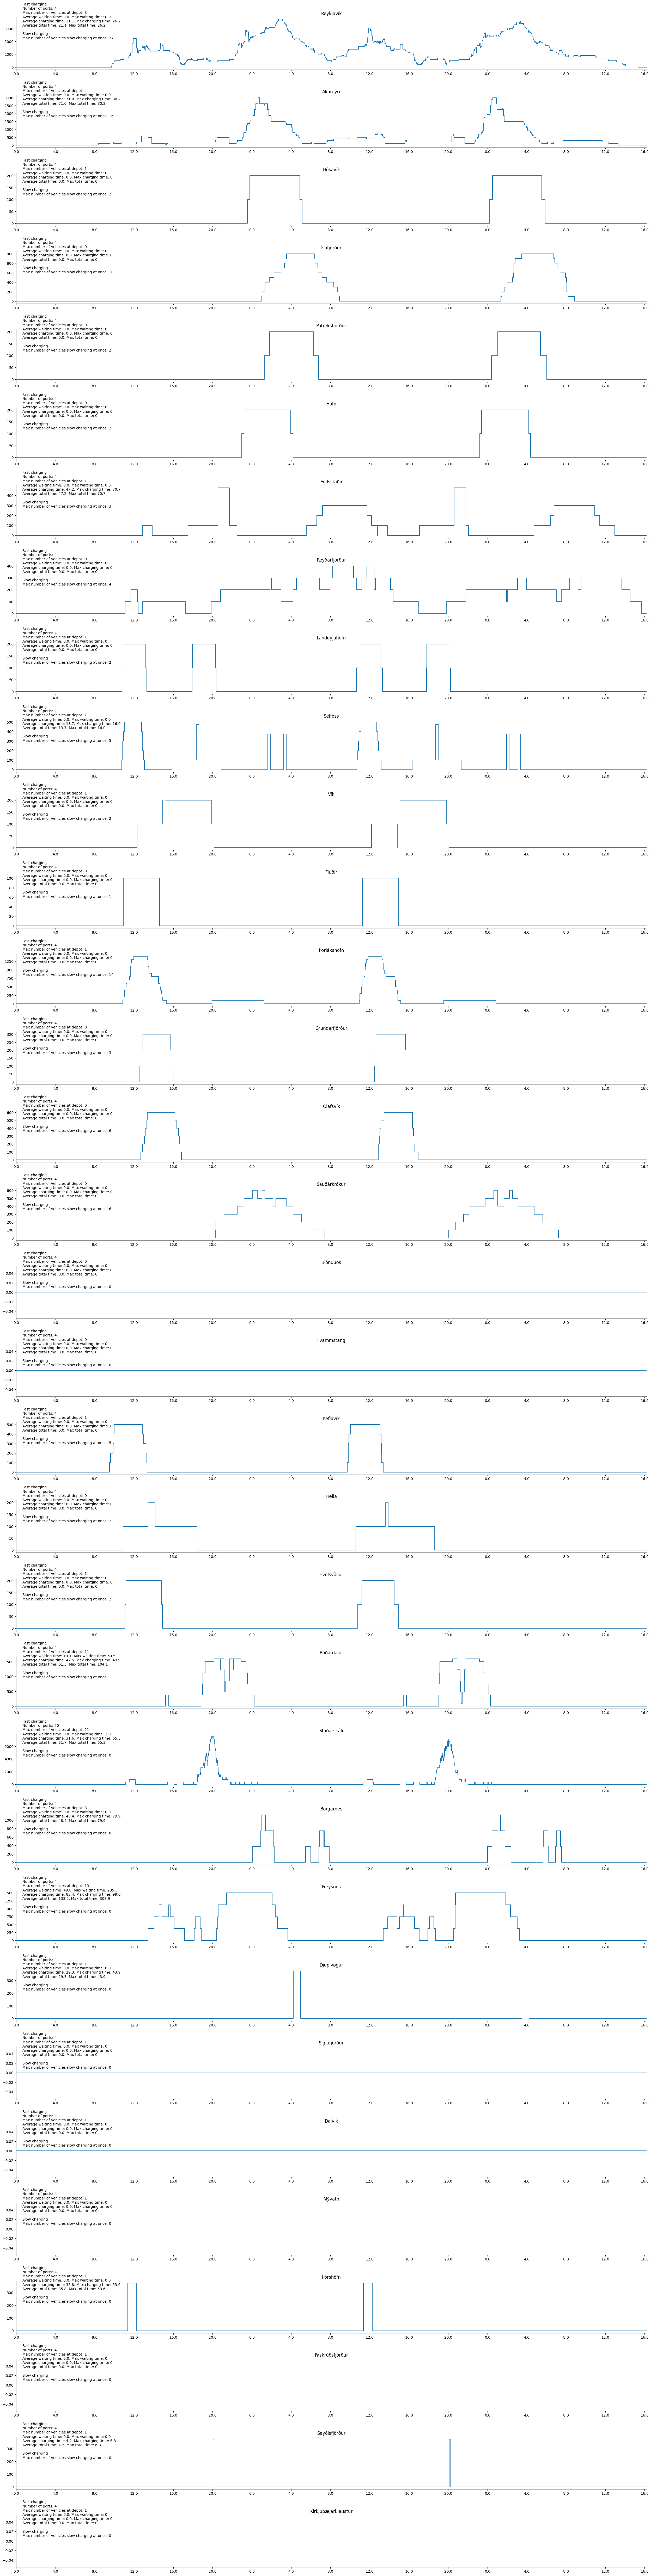

In [ ]:
spines = ["top","right","left","bottom"]
fig,ax = plt.subplots(len(DepotList),1,figsize=(25,3*len(DepotList)))

MaxTime = max(truck_data['Destination time'])+400
MinTime = 0

Depot_data = pd.DataFrame()



for count, instance in enumerate(Depot.instances):
    df = pd.DataFrame()
    df = instance.d.drop_duplicates(subset=[instance.time_name],keep='last')
    df = df.reset_index(drop=True)
    df.loc[len(df)]=[MaxTime,0]
    ax[count].plot(df[instance.time_name],df[instance.power_name],drawstyle = 'steps-post')
    ax[count].set_title(str(instance.name))
    print(df)
    if count == 0:
        Depot_data = df
        
    else:
        Depot_data = pd.concat([Depot_data,df],axis=1)


    df1 = pd.DataFrame()
    df1 = instance.d1.drop_duplicates(subset=[instance.time_name],keep='last')
    df1 = df1.reset_index(drop=True)

    df2 = instance.d2

    df3 = pd.DataFrame()
    df3 = instance.d3.drop_duplicates(subset=[instance.time_name],keep='last')
    df3 = df3.reset_index(drop=True)

    df4 = instance.d4

    df5 = instance.d5

    ax[count].text(0.01,0.5,
    f'Fast charging \n'
    f"Number of ports: {instance.charging_ports.capacity} \n"
    f"Max number of vehicles at depot: {int(max(instance.d1.iloc[:,1]))} \n"
    f'Average waiting time: {round(df2.iloc[:,0].mean(),1)}. Max waiting time: {round(df2.iloc[:,0].max(),1)} \n'
    f'Average charging time: {round(df4.iloc[:,0].mean(),1)}. Max charging time: {round(df4.iloc[:,0].max(),1)} \n'
    f'Average total time: {round(df5.iloc[:,0].mean(),1)}. Max total time: {round(df5.iloc[:,0].max(),1)} \n'
    f'\nSlow charging \n'
    f'Max number of vehicles slow charging at once: {int(max(instance.d3.iloc[:,1]))} \n'
    
    ,transform=ax[count].transAxes)
fig.tight_layout()


for ax in ax:
    for s in spines:
        if s == "top" or s == "right":
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_edgecolor("gray")
    ax.set_xlim(MinTime,MaxTime)
    ax.set_xticks(np.arange(MinTime,MaxTime,240))
    ax.set_xticklabels(np.resize(np.arange(MinTime,1440,240)/60,sum(i<MaxTime for i in (np.arange(MinTime,MaxTime+60,240)))))
    
    #ax.set_xlabel('Klst')

plt.savefig('Simpy_depot')

IndexError: list index out of range

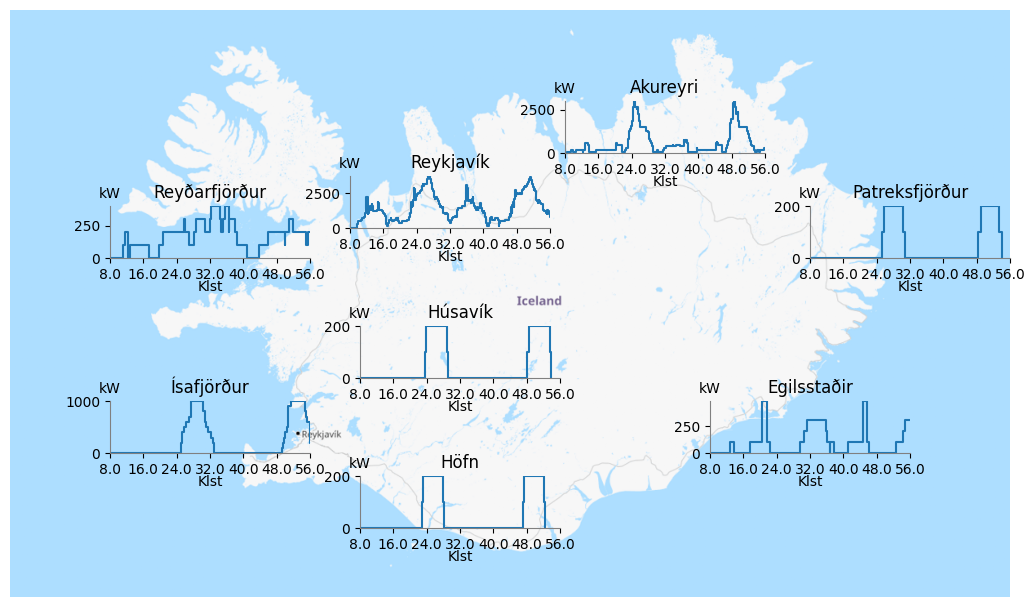

In [ ]:
fig = plt.figure(figsize=(10, 15),facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
im = plt.imread("Iceland map.PNG")
implot = plt.imshow(im)
#plt.xticks([])
#plt.yticks([])

spines = ["top","right","left","bottom"]

MaxTime = max(truck_data['Destination time'])

loc = [
[.34, .55, .2, .035], # Staðarskáli
[.555, .6, .2, .035], # AK
[.35, .45, .2, .035], # Borgarnes
[.1, .4, .2, .035], # Reykjavík
[.8, .53, .2, .035], # Egilstaðir
[.35, .35, .2, .035], # Selfoss
[.7, .4, .2, .035], # Freysnes
[.1, .53, .2, .035], # Búðardalur

]
    

for count, instance in enumerate(Depot.instances):
    df = pd.DataFrame()
    df = instance.d.drop_duplicates(subset=[instance.time_name],keep='last')
    df = df.reset_index(drop=True)
    #df.loc[len(df)]=[MaxTime,0]

    a = plt.axes(loc[count])
    
    a.plot(df[instance.time_name],df[instance.power_name],drawstyle = 'steps-post')
    a.set_title(str(instance.name))

    for s in spines:
        if s == "top" or s == "right":
            a.spines[s].set_visible(False)
        else:
            a.spines[s].set_edgecolor("gray")
    a.set_xlim(480,MaxTime-240)
    a.set_ylim(0,df.iloc[:,1].max())
    #if df.iloc[:,1].max() > 500:
    #    a.set_ylim(0,1000)
    a.set_xticks(np.arange(480,MaxTime+60,480))
    a.set_xticklabels(np.arange(480,MaxTime+60,480)/60)
    a.set_xlabel('Klst')
    a.set_ylabel('kW',rotation=0)
    a.yaxis.set_label_coords(0,1.1)
    a.xaxis.set_label_coords(0.5,-0.4)


    a.set_facecolor('none')
    a.set_alpha(0.1)
    



plt.savefig('Simpy_depot map')